In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from util_visualization import plot_feature_importances, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import joblib
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import glob

## Import Data

In [3]:
# Load the labeled index data from csv
labeled_index = pd.read_csv("../data/labeled_data/lagged_labeled_data.csv")

In [4]:
labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())

In [5]:
columns_to_remove = ['index', 'crash_label', 'date', 'Quarter']
features_columns = [column for column in list(labeled_index.columns) if column not in columns_to_remove]
features_columns

['000001.SS',
 '^BSESN',
 '^BVSP',
 '^FCHI',
 '^FTLC',
 '^GDAXI',
 '^GSPC',
 '^HSI',
 '^N225',
 '^SSMI',
 'volatility_lag1',
 'volatility_lag2',
 'price_change_lag1',
 'price_change_lag2',
 'volume_change_lag1',
 'volume_change_lag2',
 'Crude_Oil_Index_Excess_Return_lag1',
 'Crude_Oil_Index_Excess_Return_lag2',
 'Ted_Rate_lag1',
 'Ted_Rate_lag2',
 'Gold_Price_lag1',
 'Gold_Price_lag2',
 'housing_lag1',
 'housing_lag2',
 'reserve_lag1',
 'reserve_lag2',
 '10YGov_BondYield_lag1',
 '10YGov_BondYield_lag2',
 'current_acct_lag1',
 'current_acct_lag2',
 'FX_Rate_lag1',
 'FX_Rate_lag2',
 'turnover_lag1',
 'turnover_lag2',
 'Population_lag1',
 'Population_lag2',
 'npl_lag1',
 'npl_lag2',
 'Recession_Indicators_lag1',
 'Recession_Indicators_lag2',
 'inflation_lag1',
 'inflation_lag2',
 'Unemployment_lag1',
 'Unemployment_lag2',
 'GDP_lag1',
 'GDP_lag2']

## Build the model

In [6]:
# Call TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
evaluation = []
shap_values_list = []
best_params_list = []

for train_index, val_test_index in tscv.split(quarters):
    val_index = val_test_index[:int(len(val_test_index) * 0.5)]
    test_index = val_test_index[int(len(val_test_index) * 0.5):]
    train_quarters, val_quarters, test_quarters = quarters[train_index], quarters[val_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    val = labeled_index.loc[val_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_val = val[features_columns]
    y_val = val['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE()
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Hyperparameter Tuning with val
    if not all(label == 0 for label in y_val):
        param_grid = {"penalty": ['none', 'l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs', 'liblinear', 'sag', 'saga'], 'class_weight': [None, 'balanced']}
        grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=tscv, scoring='f1', verbose=2)
        grid_search.fit(X_val, y_val)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_params_list.append(best_params)
        print(f"Best Score: {best_score}")
        print("Grid search completed successfully.")
    else:
        best_params = best_params_list[-1]
    
    # Train the model
    model = LogisticRegression(penalty=best_params['penalty'], C=best_params['C'], solver=best_params['solver'], class_weight=best_params['class_weight'])
    model.fit(X_train_resampled, y_train_resampled)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Predict probabilities on the test data
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    conf_matrix = confusion_matrix(y_test, y_pred, labels= [0,1])
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X_test)
    shap_values_list.append(shap_values)
    
    evaluation_result = {
        'Train_Start': pd.to_datetime(train_quarters).min(),
        'Train_End': pd.to_datetime(train_quarters).max(),
        'Val_Start': pd.to_datetime(val_quarters).min(),
        'Val_End': pd.to_datetime(val_quarters).max(),
        'Test_Start': pd.to_datetime(test_quarters).min(),
        'Test_End': pd.to_datetime(test_quarters).max(),
        'Confusion_Matrix': conf_matrix, #[[TN, FP],[FN,TP]]
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1, 
        'Accuracy': accuracy, 
        'RMSE': rmse,
        'MAPE': mape,
        'AUC-ROC': auc_roc,
        'False Positive Rate': fpr,
        'True Positive Rate': tpr
    }
    
    # Feature Importance
    feature_names = list(X_train.columns)
    feature_importance = model.coef_[0]
    for name, importance in zip(feature_names, feature_importance):
        evaluation_result[f"{name}_importance"] = importance

    # Append result to evaluation
    evaluation.append(evaluation_result)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=sag; total time=   

[CV] END ..C=0.01, class_weight=None, penalty=l1, solver=sag; total time=   0.0s
[CV] END ..C=0.01, class_weight=None, penalty=l1, solver=sag; total time=   0.0s
[CV] END ..C=0.01, class_weight=None, penalty=l1, solver=sag; total time=   0.0s
[CV] END ..C=0.01, class_weight=None, penalty=l1, solver=sag; total time=   0.0s
[CV] END ..C=0.01, class_weight=None, penalty=l1, solver=sag; total time=   0.0s
[CV] END .C=0.01, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END .C=0.01, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END .C=0.01, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END .C=0.01, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END .C=0.01, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weigh

[CV] END ..C=0.1, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, 

[CV] END .C=1, class_weight=balanced, penalty=l1, solver=sag; total time=   0.0s
[CV] END .C=1, class_weight=balanced, penalty=l1, solver=sag; total time=   0.0s
[CV] END .C=1, class_weight=balanced, penalty=l1, solver=sag; total time=   0.0s
[CV] END .C=1, class_weight=balanced, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=1, class_weigh

[CV] END C=10, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=100, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=100, clas

[CV] END C=1000, class_weight=None, penalty=none, solver=sag; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=sag; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=sag; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=sag; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=1000, class_

Fitting 5 folds for each of 168 candidates, totalling 840 fits
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=sag; total time=   

[CV] END C=0.01, class_weight=None, penalty=none, solver=sag; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=none, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, cl

[CV] END ..C=0.1, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..C=0.1, class_weight=None, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=n

[CV] END C=1, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=1, class_weight=balanced, penalty=l1, solver=sag; total time=   0.0s
[CV] END .C=1, class_weight=balanced, penalty=l1, solver=sag; total time=   0.0s
[CV] END .C=1, class_weight=balanced, penalty=l1, solver=sag; total time=   0.0s
[CV] END .C=1, class_weight=balanced, penalty=l1, solver=sag; total time=   0.0s
[CV] END .C=1, class_weight=balanced, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV

[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=sag; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=10, class_weight=balanced, penalty=l2, solver=saga; total time=   0

[CV] END C=100, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l2, solver=saga; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=1000, class_weight=None, penalty=none, solver=liblinear; total time=

Fitting 5 folds for each of 168 candidates, totalling 840 fits
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.001, class_weight=None, penalty=none, solver=sag; total time=   

[CV] END C=0.01, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, class_weight=None, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..C=0.01, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ..C=0.01, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ..C=0.01, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ..C=0.01, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END ..C=0.01, class_weight=None, penalty=l2, solver=sag; total time=   0.0s
[CV] END

[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, penalty=l2, solver=liblinear

[CV] END C=10, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=10, class_weight=None, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=10, class_weight=None, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....C=10, class_weight=None, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....C=10, class_weight=None, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....C=10, class_weight=None, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....C=10, class_weight=None, penalty=l1, solver=sag; total time=   0.0s
[CV] END ...C=10, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...C=10, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...C=10, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...C=10, class_weight=None, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...C=10, clas

[CV] END C=100, class_weight=balanced, penalty=none, solver=sag; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=none, solver=sag; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=none, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=none, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=none, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=none, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=none, solver=saga; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=100, class_weight=balanced, penalty=l1, solver=lbfgs; total 

In [7]:
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('./evaluation_result/' + f"evaluation_Log_Regression_all_features.csv", index=False)
evaluation_df

,Train_Start,Train_End,Val_Start,Val_End,Test_Start,Test_End,Confusion_Matrix,Precision,Recall,F1,...,npl_lag1_importance,npl_lag2_importance,Recession_Indicators_lag1_importance,Recession_Indicators_lag2_importance,inflation_lag1_importance,inflation_lag2_importance,Unemployment_lag1_importance,Unemployment_lag2_importance,GDP_lag1_importance,GDP_lag2_importance
0,1998-09-30,2002-06-30,2002-09-30,2004-03-31,2004-06-30,2005-12-31,"[[49, 19], [1, 1]]",0.050000,0.500000,0.090909,...,-0.000152,0.000607,0.017460,0.002081,-0.000416,-0.010665,0.001686,0.012509,0.014710,0.007234
1,1998-09-30,2005-12-31,2006-03-31,2007-09-30,2007-12-31,2009-06-30,"[[25, 17], [14, 14]]",0.451613,0.500000,0.474576,...,0.000000,2.041042,2.175794,-1.606631,0.747432,-1.570996,-0.528537,0.820451,1.050296,-0.955592
2,1998-09-30,2009-06-30,2009-09-30,2011-03-31,2011-06-30,2012-12-31,"[[39, 25], [5, 1]]",0.038462,0.166667,0.062500,...,-6.298564,6.165149,1.825472,-0.914284,0.154702,-0.354581,-1.000222,1.133512,0.584373,-0.663973
3,1998-09-30,2012-12-31,2013-03-31,2014-09-30,2014-12-31,2016-06-30,"[[35, 24], [9, 2]]",0.076923,0.181818,0.108108,...,-7.745962,7.731794,1.675093,-0.920366,0.345146,-0.142112,-0.699219,0.616175,0.466432,-0.498362
4,1998-09-30,2016-06-30,2016-09-30,2018-03-31,2018-06-30,2019-12-31,"[[40, 29], [1, 0]]",0.000000,0.000000,0.000000,...,-4.187584,4.563384,1.854126,-1.068276,0.208851,-0.158810,-0.786978,0.664820,0.182833,-0.276941


## Shap Values

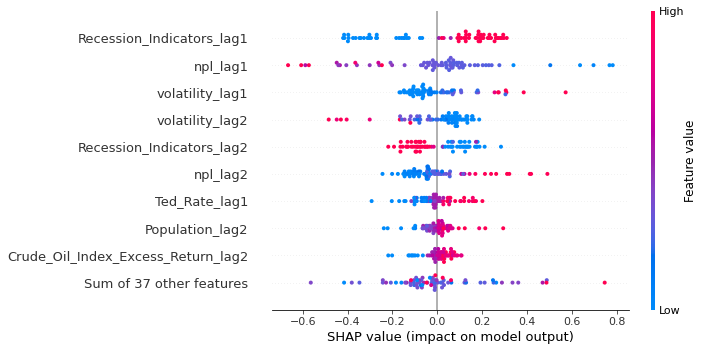

In [8]:
shap.plots.beeswarm(shap_values_list[4])

## Feature Importance

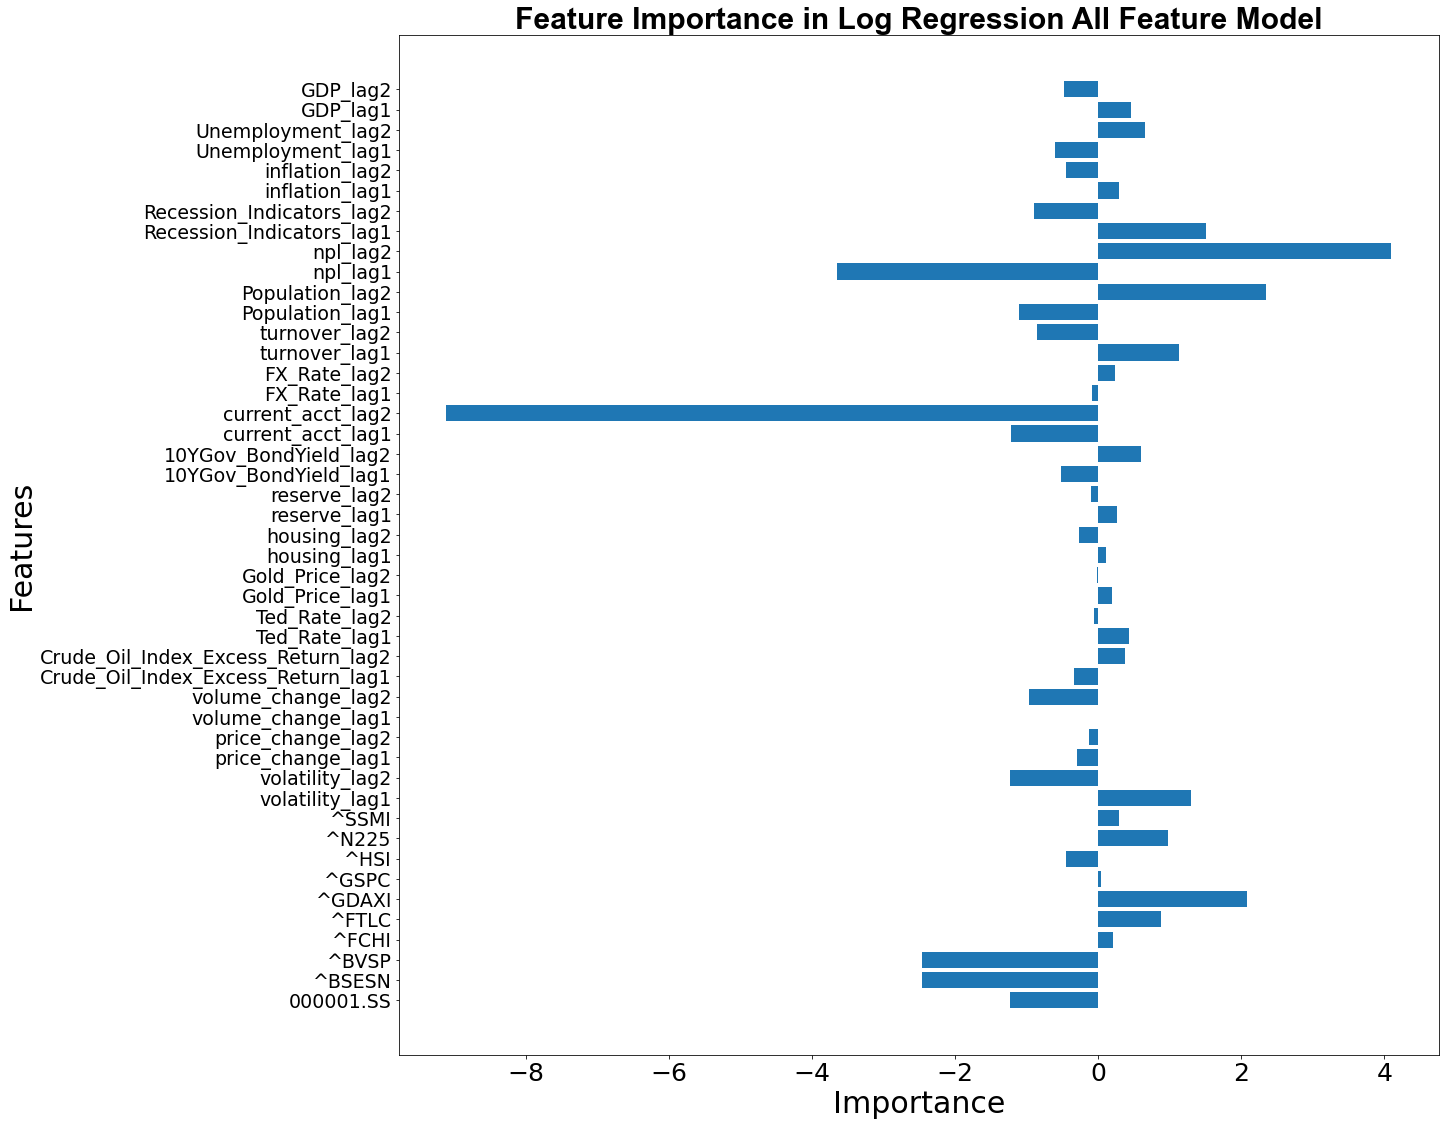

In [19]:
model_name = "Log Regression All Feature"
plot_feature_importances(evaluation_df, model_name)

In [10]:
importance_columns = [col for col in evaluation_df.columns if col.endswith("_importance")]

# Calculate the average importance value for each feature
importance_avgs = evaluation_df[importance_columns].mean(axis=0)
cleaned_index = [index.replace("_importance", "") for index in importance_avgs.index]
importance_avgs = pd.Series(importance_avgs.values, index=cleaned_index)

In [11]:
# Eliminate 30% of features with least abs importance coef
abs_importance_avgs = importance_avgs.abs().sort_values(ascending=False)
col_to_eliminate = ['^BSESN', '^BVSP', '^FCHI', '^FTLC', '^GDAXI', '^GSPC', '^HSI', '^N225', '^SSMI', '000001.SS']
abs_importance_avgs = abs_importance_avgs.drop(col_to_eliminate)

num_rows_to_eliminate = int(len(abs_importance_avgs) * 0.3)
abs_importance_avgs = abs_importance_avgs[:-num_rows_to_eliminate]

In [111]:
selected_features = abs_importance_avgs.index.to_numpy()
selected_features

array(['current_acct_lag2', 'npl_lag2', 'npl_lag1', 'Population_lag2',
       'Recession_Indicators_lag1', 'Population_lag1', 'volatility_lag1',
       'volatility_lag2', 'current_acct_lag1', 'turnover_lag1',
       'volume_change_lag2', 'Recession_Indicators_lag2', 'turnover_lag2',
       'Unemployment_lag2', '10YGov_BondYield_lag2',
       '10YGov_BondYield_lag1', 'Unemployment_lag1', 'Ted_Rate_lag1',
       'GDP_lag2', 'inflation_lag2', 'GDP_lag1',
       'Crude_Oil_Index_Excess_Return_lag2',
       'Crude_Oil_Index_Excess_Return_lag1', 'housing_lag2',
       'price_change_lag1', 'inflation_lag1'], dtype=object)

## AUC-ROC

In [112]:
print("Mean AUC Score: ", np.mean(evaluation_df['AUC-ROC']))

Mean AUC Score:  0.4899346753841886


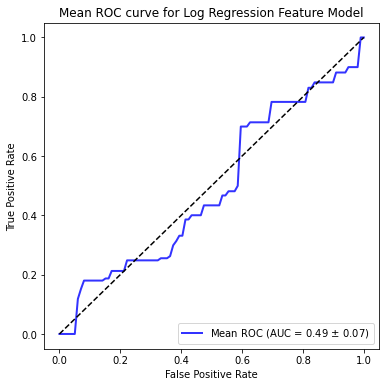

In [113]:
plot_roc_curve(evaluation_df, model_name)